### Описание задания

Построить классификатор изображений рукописного ввода на базе MNIST на основе [датасета](https://www.kaggle.com/c/digit-recognizer).

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную модель, за исключением сверточных нейронных сетей.
Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6.

In [17]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

### Первичная обработка данных

In [2]:
train = np.loadtxt('./data/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/test.csv', delimiter=',', skiprows=1)

In [3]:
train_label = train[:, 0]
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

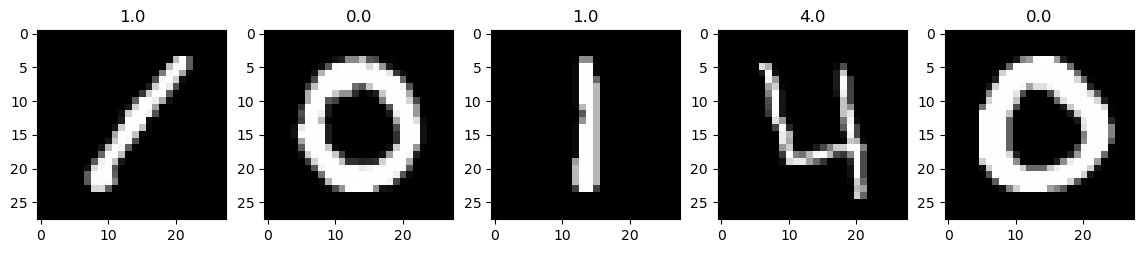

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [5]:
train.shape, train_label.shape, test.shape

((42000, 785), (42000,), (28000, 784))

### Обучение модели на основе гистограммы градиентов (HOG)

Вычисляем X и Y составляющие градиента с помощью оператора Собеля.

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
    
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

Вычисляем угол и длину вектора градиента.

In [7]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

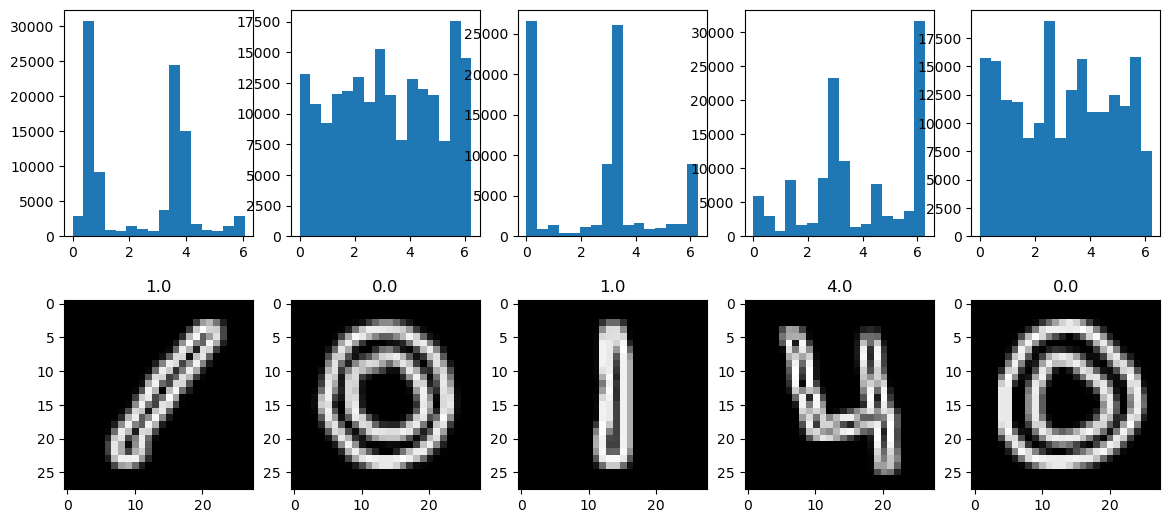

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

Вычисляем гистограммы градиентов с учетом длины вектора градиента.

In [9]:
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

Нормируем вектор гистограммы.

In [10]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

Обучение модели на основе train данных.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_hist, train_label, test_size=0.3, random_state=21)

In [19]:
model = SVC(random_state=21)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [20]:
report = classification_report(y_val, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.45      0.47      0.46      1210
         1.0       0.97      0.95      0.96      1363
         2.0       0.52      0.49      0.51      1234
         3.0       0.62      0.70      0.66      1269
         4.0       0.71      0.73      0.72      1267
         5.0       0.66      0.64      0.65      1155
         6.0       0.50      0.46      0.48      1277
         7.0       0.86      0.80      0.83      1339
         8.0       0.55      0.60      0.57      1200
         9.0       0.69      0.68      0.68      1286

    accuracy                           0.66     12600
   macro avg       0.65      0.65      0.65     12600
weighted avg       0.66      0.66      0.66     12600



Предсказание метки на основе test данных.

In [54]:
pred_test = model.predict(test_hist)

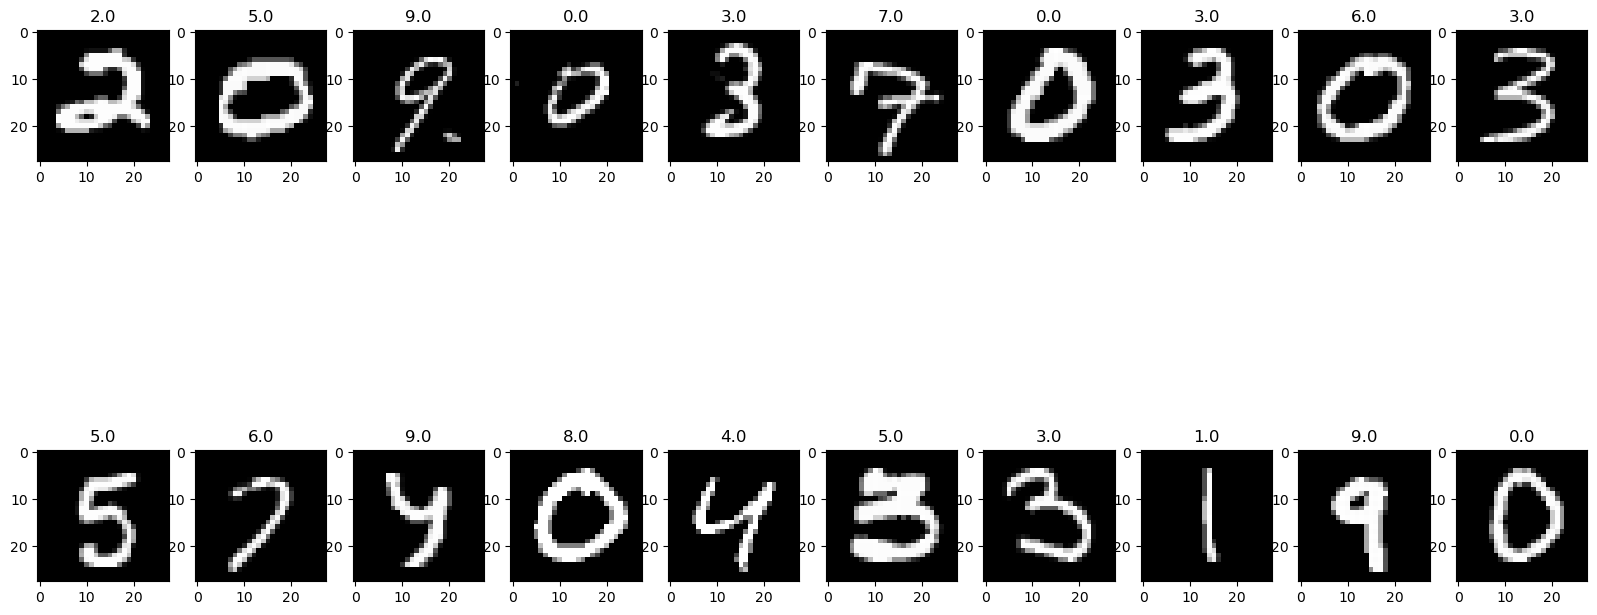

In [55]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

**Вывод:** Для классификатора построенного на признаках, полученных в результате предобработки изображений с помощью гистограммы градиентов(HOG) была полученна accuracy **0.66**. Для test данных была построена визуализация с полученными метками.

### Обучение модели на основе результата PCA преобразования.

In [25]:
X_train, X_val, y_train, y_val = train_test_split(train[:, 1:], train_label, test_size=0.3, random_state=21)

In [28]:
cov_matrix = np.matmul(X_train.T, X_train)
cov_matrix.shape

(784, 784)

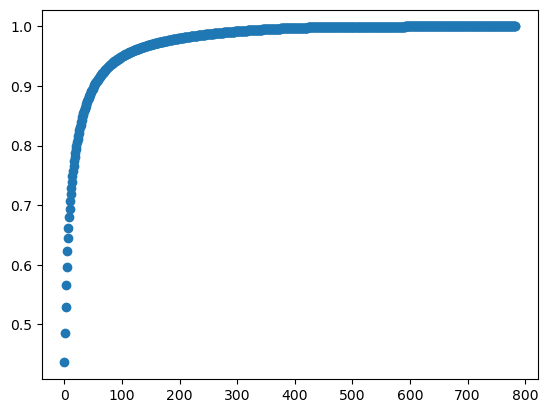

In [29]:
U, S, _ = np.linalg.svd(cov_matrix)
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

Зададим порог для накопленной суммы собственных значений 0.85

In [32]:
S_thr = 0.85
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=32 S=0.851


Обучим модель, используя PCA преобразование для полученного числа компонент.

In [35]:
model_rfc = make_pipeline(PCA(n_components=32,
                              copy = True,
                              whiten = False,
                              svd_solver = 'auto',
                              tol = 0.0, 
                              iterated_power = 'auto',
                              random_state = 21),
                          StandardScaler(), 
                          SVC(random_state=21))
model_rfc.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=32, random_state=21)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=21))])

In [36]:
pred = model_rfc.predict(X_val)
report = classification_report(y_val, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1210
         1.0       0.99      0.99      0.99      1363
         2.0       0.97      0.98      0.98      1234
         3.0       0.98      0.96      0.97      1269
         4.0       0.97      0.98      0.97      1267
         5.0       0.97      0.98      0.97      1155
         6.0       0.99      0.99      0.99      1277
         7.0       0.97      0.97      0.97      1339
         8.0       0.98      0.98      0.98      1200
         9.0       0.97      0.96      0.97      1286

    accuracy                           0.98     12600
   macro avg       0.98      0.98      0.98     12600
weighted avg       0.98      0.98      0.98     12600



In [46]:
pred_test = model_rfc.predict(test)

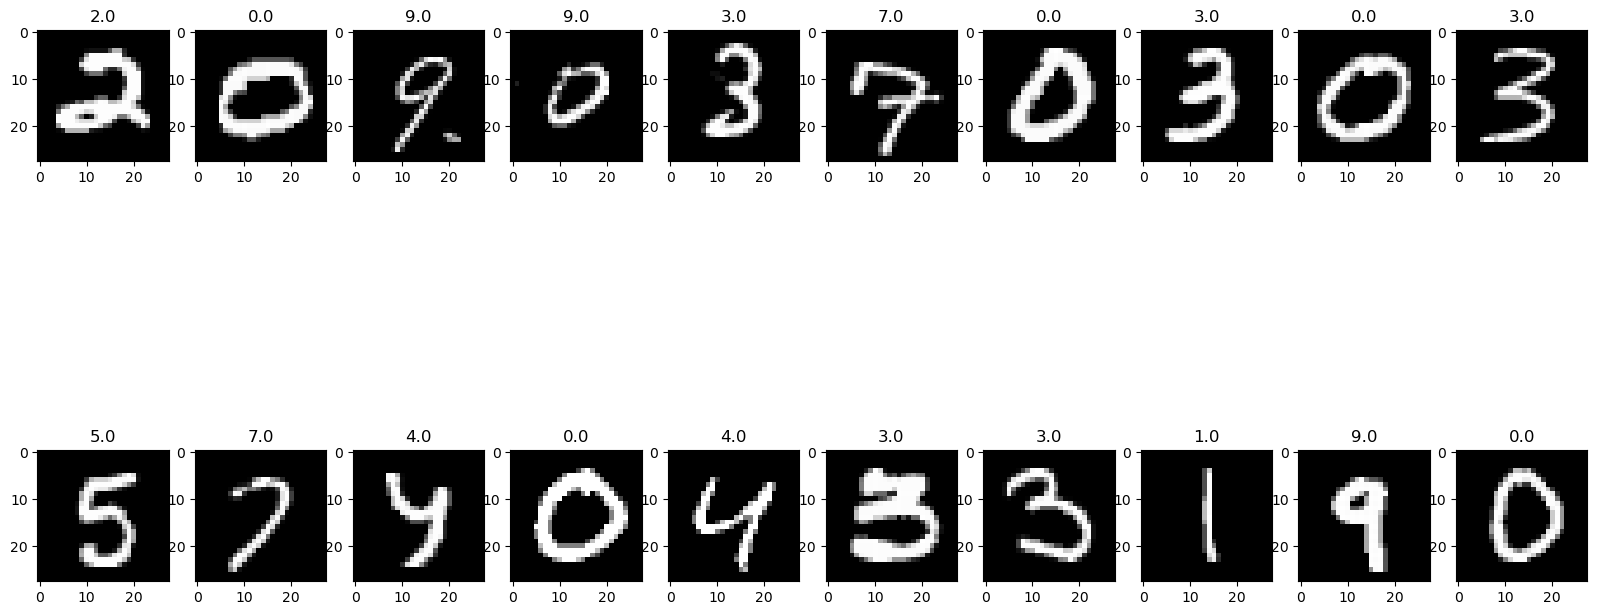

In [53]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

**Вывод:** Для классификатора построенного на признаках, полученных на результате PCA преобразования, была полученна accuracy **0.98**. Для test данных была построена визуализация с полученными метками.

### Выводы:

Были построены классификаторы SVC на основе признаков, полученных на основе обработки изображения с помощью:
- гистограммы градиентов (HOG): получено accuracy **0.66**
- PCA преобразования: получено accuracy **0.98**